# BASICS 03 - HOTS with online classification (Grimaldi et al. 2022)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig
import matplotlib.pyplot as plt

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset)
num_sample_train = len(loader)
num_sample_test = len(testset)
print(f'number of samples in the training set: {len(loader)}')

number of samples in the training set: 48


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-04-27'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name

device -> cuda
device -> cuda


## Unsupervised clustering

In [5]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering)

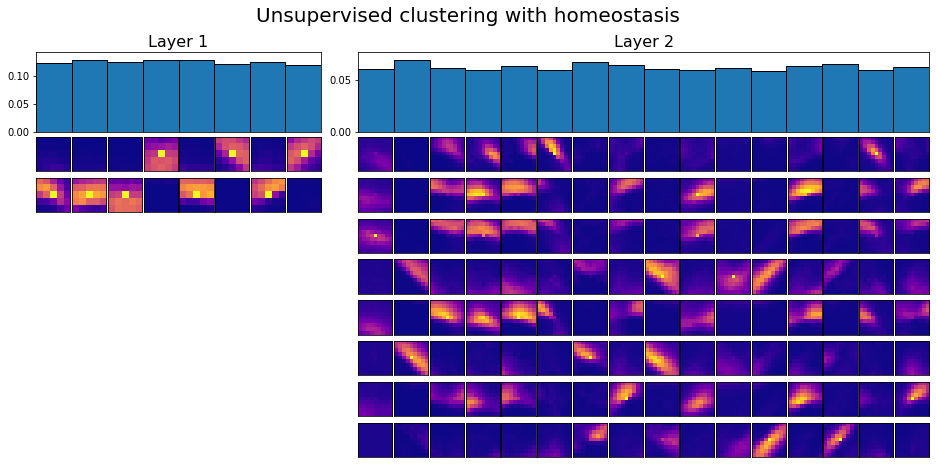

In [6]:
hots.plotlayers();

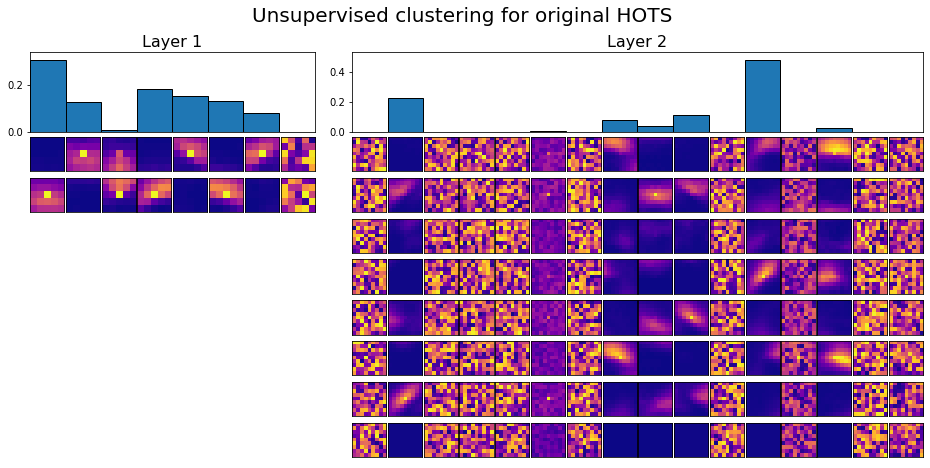

In [7]:
hots_nohomeo.plotlayers();

## Training of the classification layer

In [8]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 2e4

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
trainloader = get_loader(trainset_output)
classif_layer, losses = fit_mlr(trainloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

hots_nohomeo.coding(loader, trainset.ordering, trainset.classes, training=True)

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
model_path_nohomeo = f'../Records/networks/{hots_nohomeo.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
trainloader_nohomeo = get_loader(trainset_output_nohomeo)
classif_layer_nohomeo, losses_nohomeo = fit_mlr(trainloader_nohomeo, model_path_nohomeo, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

../Records/networks/2022-04-27_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_20000.0_0.005_(0.9, 0.999)_33_(None, None).pkl
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-27_poker_homeohots_False_[8, 16]_[1000.0, 4000.0]_[2, 4]_48_(None, None)/


In [9]:
import numpy as np
from tqdm import tqdm

if not os.path.exists('../Records/jitter_results/'):
    os.mkdir('../Records/jitter_results/')

nb_trials = 10
n_classes = len(testset.classes)

std_jit_s_min = 0
std_jit_s_max = 10
std_jit_s = np.linspace(0,10,20)
var_jit_s = std_jit_s**2
scores_jit_s = np.zeros([nb_trials, len(var_jit_s)])
scores_jit_s_histo = np.zeros([nb_trials, len(var_jit_s)])
scores_jit_s_histo_nohomeo = np.zeros([nb_trials, len(var_jit_s)])

jitter_path = f'../Records/jitter_results/{initial_name}_{nb_trials}_{std_jit_s_min}_{std_jit_s_max}'
if not os.path.exists(jitter_path+'.npz'):

    torch.set_default_tensor_type("torch.DoubleTensor")

    for trial in tqdm(range(nb_trials)):
        for ind_jit, spatial_jitter in enumerate(var_jit_s):
            if spatial_jitter==0:
                jitter = (None,None)
            else:
                jitter = (spatial_jitter,None)
            test_path = f'../Records/output/test/{initial_name}_{trial}_{num_sample_test}_{jitter}/'
            results_path = f'../Records/LR_results/{initial_name}_{trial}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
            hots.name = initial_name+f'_{trial}'

            spatial_jitter_transform = tonic.transforms.SpatialJitter(sensor_size = trainset.sensor_size, variance_x = spatial_jitter, variance_y = spatial_jitter, clip_outliers = True)
            spatial_jitter_transform_full = tonic.transforms.Compose([spatial_jitter_transform, type_transform])
            testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=spatial_jitter_transform_full)
            loader = get_loader(testset)
            hots.coding(loader, testset.ordering, testset.classes, training=False, jitter = jitter, verbose=False)

            testset_output = HOTS_Dataset(test_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
            testloader = get_loader(testset_output)

            likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testloader,results_path,ts_size,testset_output.ordering)
            meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, verbose=False)

            scores_jit_s_histo[trial,ind_jit] = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
            scores_jit_s[trial,ind_jit] = lastac

            test_path_nohomeo = f'../Records/output/test/{initial_name_nohomeo}_{trial}_{num_sample_test}_{jitter}/'
            results_path_nohomeo = f'../Records/LR_results/{initial_name_nohomeo}_{trial}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
            hots_nohomeo.name = initial_name_nohomeo+f'_{trial}'

            hots_nohomeo.coding(loader, testset.ordering, testset.classes, training=False, jitter=jitter, verbose=False)
            testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)

            scores_jit_s_histo_nohomeo[trial,ind_jit] = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])
            np.savez(jitter_path, std_jit_s,scores_jit_s,scores_jit_s_histo,scores_jit_s_histo_nohomeo)
else:
    data_stored = np.load(jitter_path+'.npz')
    std_jit_s = data_stored['arr_0']
    scores_jit_s = data_stored['arr_1']
    scores_jit_s_histo = data_stored['arr_2']
    scores_jit_s_histo_nohomeo = data_stored['arr_3']

In [10]:
std_jit_t_min = 2.5
std_jit_t_max = 5.5
std_jit_t = np.logspace(std_jit_t_min,std_jit_t_max,20)
scores_jit_t = np.zeros([nb_trials, len(std_jit_t)])
scores_jit_t_histo = np.zeros([nb_trials, len(std_jit_t)])
scores_jit_t_histo_nohomeo = np.zeros([nb_trials, len(std_jit_t)])

jitter_path = f'../Records/jitter_results/{initial_name}_{nb_trials}_{std_jit_t_min}_{std_jit_t_max}'
if not os.path.exists(jitter_path+'.npz'):

    torch.set_default_tensor_type("torch.DoubleTensor")

    for trial in tqdm(range(nb_trials)):
        for ind_jit, temporal_jitter in enumerate(std_jit_t):
            if temporal_jitter==0:
                jitter = (None,None)
            else:
                jitter = (None,temporal_jitter)
            test_path = f'../Records/output/test/{initial_name}_{trial}_{num_sample_test}_{jitter}/'
            results_path = f'../Records/LR_results/{initial_name}_{trial}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
            hots.name = initial_name+f'_{trial}'

            tonic.transforms.TimeJitter(std = temporal_jitter, clip_negative = True, sort_timestamps = True)
            temporal_jitter_transform = tonic.transforms.TimeJitter(std = temporal_jitter, clip_negative = True, sort_timestamps = True)
            temporal_jitter_transform_full = tonic.transforms.Compose([temporal_jitter_transform, type_transform])
            testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=temporal_jitter_transform_full)
            loader = get_loader(testset)
            hots.coding(loader, testset.ordering, testset.classes, training=False, jitter = jitter, verbose=False)

            testset_output = HOTS_Dataset(test_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
            testloader = get_loader(testset_output)

            likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testloader,results_path,ts_size,testset_output.ordering)
            meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, verbose=False)

            scores_jit_t_histo[trial,ind_jit] = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
            scores_jit_t[trial,ind_jit] = lastac

            test_path_nohomeo = f'../Records/output/test/{initial_name_nohomeo}_{trial}_{num_sample_test}_{jitter}/'
            results_path_nohomeo = f'../Records/LR_results/{initial_name_nohomeo}_{trial}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
            hots_nohomeo.name = initial_name_nohomeo+f'_{trial}'

            hots_nohomeo.coding(loader, testset.ordering, testset.classes, training=False, jitter=jitter, verbose=False)
            testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)

            scores_jit_t_histo_nohomeo[trial,ind_jit] = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])
            np.savez(jitter_path, std_jit_t,scores_jit_t,scores_jit_t_histo,scores_jit_t_histo_nohomeo)
else:
    data_stored = np.load(jitter_path+'.npz')
    std_jit_t = data_stored['arr_0']
    scores_jit_t = data_stored['arr_1']
    scores_jit_t_histo = data_stored['arr_2']
    scores_jit_t_histo_nohomeo = data_stored['arr_3']

In [11]:
colorz = ['#2ca02c','#1f77b4','#d62728']

fitting = True
logscale = True

std_jit_t *= 1e-3

semi saturation level for online HOTS (ours): 25.65 ms
semi saturation level for HOTS with homeostasis: 3.16 ms
semi saturation level for original HOTS: 4.48 ms


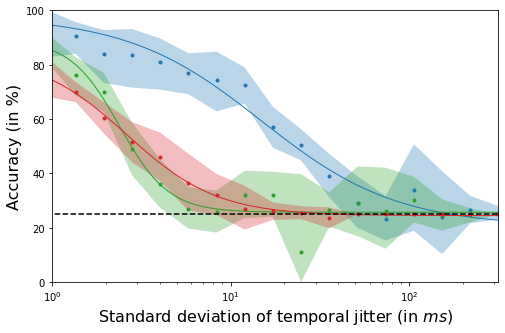

In [12]:
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))
param_T = [.99, 1/n_classes, 20, 1]
label = 'online HOTS (ours)'
n_epoch = 33
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, std_jit_t, scores_jit_t, param = param_T, color=colorz[1], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')
    
label = 'HOTS with homeostasis'
param_T = [.9, 1/n_classes, 3, 1]
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, std_jit_t, scores_jit_t_histo, param = param_T, color=colorz[0], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

label = 'original HOTS'
param_T = [.8,1/n_classes, 3, 1]
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, std_jit_t, scores_jit_t_histo_nohomeo, param = param_T, color=colorz[2], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

chance_t = np.ones([len(std_jit_t)])*100/n_classes
ax_t.plot(std_jit_t,chance_t, 'k--', label='chance level')
ax_t.axis([1,max(std_jit_t),0,100]);
ax_t.set_xlabel('Standard deviation of temporal jitter (in $ms$)', fontsize=16);
ax_t.set_ylabel('Accuracy (in %)', fontsize=16);
#ax_t.set_yticks([]);
#ax_t.set_title('Accuracy as a function of temporal jitter', fontsize=16);
#ax_t.legend(fontsize=12);

semi saturation level for online HOTS (ours): 6.26 pixels
semi saturation level for HOTS with homeostasis: 2.73 pixels
semi saturation level for original HOTS: 2.42 pixels


/home/antoine/homhots/hotsline/hots/utils.py:485: RuntimeWarning: divide by zero encountered in power
  x = jitter**powa
/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: invalid value encountered in true_divide
  output = Rmax-Rmax*x/(x+jitter0)+Rmin
/home/antoine/homhots/hotsline/hots/utils.py:486: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/home/antoine/homhots/hotsline/hots/utils.py:486: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/home/antoine/homhots/hotsline/hots/utils.py:486: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa


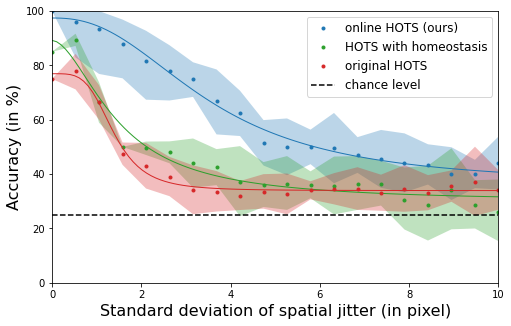

In [13]:
logscale = False

fig_s, ax_s = plt.subplots(1,1,figsize=(8,5))
param_S = [1, .4, 3, .1]
label = 'online HOTS (ours)'
n_epoch = 33
fig_s, ax_s, semisat_s = plotjitter(fig_s, ax_s, std_jit_s, scores_jit_s, param = param_S, color=colorz[1], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_s,2)} pixels')

label = 'HOTS with homeostasis'
param_S = [0.85, .3, 2, .1]
fig_s, ax_s, semisat_s = plotjitter(fig_s, ax_s, std_jit_s, scores_jit_s_histo, param = param_S, color=colorz[0], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_s,2)} pixels')

label = 'original HOTS'
param_S = [0.8, .3, 2, .1]
fig_s, ax_s, semisat_s = plotjitter(fig_s, ax_s, std_jit_s, scores_jit_s_histo_nohomeo, param = param_S, color=colorz[2], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_s,2)} pixels')

chance_s = np.ones([len(std_jit_s)])*100/n_classes
ax_s.plot(std_jit_s,chance_s, 'k--', label='chance level')
ax_s.axis([0,max(std_jit_s),0,100]);
ax_s.set_xlabel('Standard deviation of spatial jitter (in pixel)', fontsize=16);
ax_s.set_ylabel('Accuracy (in %)', fontsize=16);
#ax_s.set_title('Accuracy as a function of spatial jitter', fontsize=16);
#plt.yticks([],[])
#ax_s.set_yticks([])
ax_s.legend(fontsize=12);

In [14]:
printfig(fig_s, 'spatial_jitter_poker.pdf')
printfig(fig_t, 'temporal_jitter_poker.pdf')